In [111]:
import pandas as pd
import numpy as np
patient_records = pd.read_excel("cleaned_fat_percentage_data.xlsx")
print(patient_records.columns)
#df = pd.read_excel("cleaned_fat_percentage_data.xlsx")
#print(df.columns)

Index(['Subject.ID', 'Partition', 'Tissue.Sample.ID_pancreas', 'Sex_value',
       'Sex', 'Age_value', 'Age.Bracket', 'Hardy.Scale',
       'Pathology.Categories_pancreas', 'Pathology.Notes_pancreas',
       'Tissue.Sample.ID_liver', 'Pathology.Categories_liver',
       'Pathology.Notes_liver', 'SAMPID_pancreas', 'SMTS_pancreas',
       'SMPTHNTS_pancreas', 'SAMPID_liver', 'SMTS_liver', 'SMPTHNTS_liver',
       'Fat.Percentage_liver', 'Fat.Percentage_pancreas'],
      dtype='object')


In [112]:
gene_counts = pd.read_csv("sample_gene_count.csv")
print(gene_counts.columns)
print(gene_counts.head())

Index(['name', 'GTEX-11EQ9-0526-SM-5A5JZ', 'GTEX-11EQ9-1026-SM-5H134',
       'GTEX-11GSP-0426-SM-5A5KX', 'GTEX-11GSP-0626-SM-5986T',
       'GTEX-11TT1-0326-SM-5LUAY', 'GTEX-11TT1-1726-SM-5EQLJ',
       'GTEX-12WSD-1426-SM-5GCN9', 'GTEX-12WSD-1626-SM-5GCNR',
       'GTEX-12WSG-0626-SM-5FQTQ',
       ...
       'GTEX-ZF2S-3026-SM-4WWCH', 'GTEX-ZPU1-0226-SM-4WWC9',
       'GTEX-ZTPG-1026-SM-5DUWP', 'GTEX-ZTPG-1426-SM-51MT3',
       'GTEX-ZVP2-0626-SM-51MSO', 'GTEX-ZVP2-0726-SM-59HKY',
       'GTEX-ZYT6-0626-SM-5E45V', 'GTEX-ZYT6-1326-SM-5E453',
       'GTEX-ZYY3-0626-SM-5NQ6W', 'GTEX-ZYY3-0826-SM-5E44R'],
      dtype='object', length=162)
                name  GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11EQ9-1026-SM-5H134  \
0  ENSG00000223972.5                   0.01697                   0.00000   
1  ENSG00000227232.5                   0.86190                   1.69700   
2  ENSG00000243485.5                   0.03389                   0.00000   
3  ENSG00000237613.2                   0.00000    

In [113]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

gene_counts_transpose = gene_counts.set_index('name').transpose().reset_index()
patients_with_genes = patient_records[~patient_records['SAMPID_pancreas'].isnull()]
merged_df = pd.merge(patients_with_genes, gene_counts_transpose.add_prefix('pancreas_gene_'), left_on='SAMPID_pancreas', right_on='pancreas_gene_index', how='inner')
merged_df = pd.merge(merged_df, gene_counts_transpose.add_prefix('liver_gene_'), left_on='SAMPID_liver', right_on='liver_gene_index', how='inner')

# Convert hardy types to one hot vector
hardy_types = list(pd.get_dummies(merged_df['Hardy.Scale']).columns)
dataset = pd.concat([merged_df,  pd.get_dummies(merged_df['Hardy.Scale'])], axis=1)

# Get relevant columns
# dataset = df_one_hot_hardy[['Partition', 'Age_value', 'Sex_value'] + hardy_types + ['Fat.Percentage_liver', 'Fat.Percentage_pancreas']]

# Get relevant columns
pancrease_gene_columns = [col for col in dataset if col.startswith('pancreas_gene_') and col != 'pancreas_gene_index']
liver_gene_columns = [col for col in dataset if col.startswith('liver_gene_') and col != 'liver_gene_index']
dataset = dataset[['Partition', 'Age_value', 'Sex_value', 'Fat.Percentage_liver', 'Fat.Percentage_pancreas'] + hardy_types + pancrease_gene_columns + liver_gene_columns]

dataset_train = dataset[dataset['Partition'] == 'train'].reset_index(drop=True)
dataset_val = dataset[dataset['Partition'] == 'val'].reset_index(drop=True)
print("Train size:", dataset_train.shape)
print("Val size:", dataset_val.shape)

# Normalize scalers
#dataset['Age_value'] = ((dataset['Age_value'] - dataset['Age_value'].min()) / (dataset['Age_value'].max() - dataset['Age_value'].min())) * 2 - 1
#dataset['Sex_value'] = ((dataset['Sex_value'] - dataset['Sex_value'].min()) / (dataset['Sex_value'].max() - dataset['Sex_value'].min())) * 2 - 1

dataset['Age_value'] = (dataset['Age_value'] - dataset['Age_value'].min()) / (dataset['Age_value'].max() - dataset['Age_value'].min())
dataset['Sex_value'] = (dataset['Sex_value'] - dataset['Sex_value'].min()) / (dataset['Sex_value'].max() - dataset['Sex_value'].min())

#max_liver_percentage = max(dataset['Fat.Percentage_liver'].max(), dataset['Fat.Percentage_pancreas'].max())
#dataset['Fat.Percentage_liver'] = dataset['Fat.Percentage_liver'] / max_liver_percentage * 2 - 1
#dataset['Fat.Percentage_pancreas'] = dataset['Fat.Percentage_pancreas'] / max_liver_percentage * 2 - 1
dataset['Fat.Percentage_liver'] = (dataset['Fat.Percentage_liver'] - dataset['Fat.Percentage_liver'].min()) / (dataset['Fat.Percentage_liver'].max() - dataset['Fat.Percentage_liver'].min())
dataset['Fat.Percentage_pancreas'] = (dataset['Fat.Percentage_pancreas'] - dataset['Fat.Percentage_pancreas'].min()) / (dataset['Fat.Percentage_pancreas'].max() - dataset['Fat.Percentage_pancreas'].min()) 

for x in hardy_types:
    dataset[x] = (dataset[x] - dataset[x].min()) / (dataset[x].max() - dataset[x].min())

dataset_train = dataset[dataset['Partition'] == 'train'].reset_index(drop=True)
dataset_val = dataset[dataset['Partition'] == 'val'].reset_index(drop=True)
dataset_test = dataset[dataset['Partition'] == 'test'].reset_index(drop=True)

# dataset_ = dataset_test

print(dataset_train.columns)
print(dataset_train.shape)
print(dataset_val.shape)

Train size: (63, 101528)
Val size: (6, 101528)
Index(['Partition', 'Age_value', 'Sex_value', 'Fat.Percentage_liver',
       'Fat.Percentage_pancreas', 'Fast death - natural causes',
       'Fast death - violent', 'Intermediate death', 'Slow death',
       'Ventilator case',
       ...
       'liver_gene_ENSG00000198886.2', 'liver_gene_ENSG00000210176.1',
       'liver_gene_ENSG00000210184.1', 'liver_gene_ENSG00000210191.1',
       'liver_gene_ENSG00000198786.2', 'liver_gene_ENSG00000198695.2',
       'liver_gene_ENSG00000210194.1', 'liver_gene_ENSG00000198727.2',
       'liver_gene_ENSG00000210195.2', 'liver_gene_ENSG00000210196.2'],
      dtype='object', length=101528)
(63, 101528)
(6, 101528)


Mean squared error: 0.2829
Coefficient of determination: -49.67


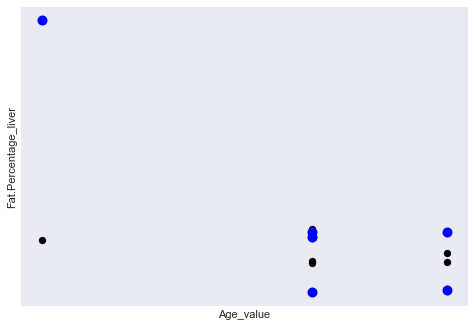

In [119]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

# ['Age_value', 'Sex_value'] + hardy_types +  ['Fat.Percentage_liver'] +
features =  pancrease_gene_columns + liver_gene_columns + ['Age_value', 'Sex_value'] + hardy_types
target = 'Fat.Percentage_liver'

x_train = dataset_train.loc[:, features].values
y_train = dataset_train.loc[:, [target]].values
feature_names = dataset_val.loc[:, features].columns

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:, [target]].values
y_val_pred = regr.predict(x_val)

#print("Target: \n", target)
#print("Features: \n", features)
#print('Coefficients: \n', regr.coef_[0].tolist())
#print('Intercept: \n', regr.intercept_)
print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))

# Plot outputs
for i, feature_name in enumerate(features):
  if feature_name not in ['Age_value']:
    continue

  plt.figure()
  plt.xlabel(feature_name)
  plt.ylabel(target)
  plt.scatter(x_val[:, i], y_val,  color='black')
  plt.scatter(x_val[:, i], y_val_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [120]:
from sklearn.svm import SVR

#print("Target: \n", target)
#print("Features: \n", features)
#for kernel in ['poly', 'rbf', 'linear']:

x_train = dataset_train.loc[:, features].values
y_train = dataset_train.loc[:, target].values

clf = SVR(degree = 2 , kernel = 'poly')
clf.fit(x_train, y_train)

x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:, target].values
y_val_pred = clf.predict(x_val)


print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

Mean squared error: 0.0067
Coefficient of determination: -0.21
----------------------------------


In [121]:
from sklearn.preprocessing import PolynomialFeatures
#for degree in [2]:
poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(x_train_poly, y_train)

x_val = dataset_val.loc[:, features].values
x_val_poly = poly.fit_transform(x_val)

y_val = dataset_val.loc[:,[target]].values
y_val_pred = poly_reg.predict(x_val_poly)
print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
#for degree in range(1,2):
poly = PolynomialFeatures(degree = 1)
x_train_poly = poly.fit_transform(x_train)
en = ElasticNet()
en.fit(x_train_poly, y_train)

x_val = dataset_val.loc[:, features].values
x_val_poly = poly.fit_transform(x_val)

y_val = dataset_val.loc[:,[target]].values
y_val_pred = en.predict(x_val_poly)
print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

In [122]:
from sklearn.ensemble import RandomForestRegressor
#for max_depth in [5, 10, 15, 20, 25, 30]:
#for n_estimators in [15]:
t_regr = RandomForestRegressor(n_estimators=100, max_depth = 3)
t_regr.fit(x_train, y_train)
x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:,[target]].values
y_val_pred = t_regr.predict(x_val)

print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

Mean squared error: 0.0150
Coefficient of determination: -1.69
----------------------------------


Feature ranking:
1. feature 65547 (0.047198)
2. feature 64184 (0.026506)
3. feature 77392 (0.023660)
4. feature 53363 (0.019267)
5. feature 75621 (0.014215)
6. feature 90899 (0.012983)
7. feature 16059 (0.012844)
8. feature 55759 (0.012348)
9. feature 78617 (0.012064)
10. feature 70583 (0.011483)
(101525,)
['liver_gene_ENSG00000251664.3', 'liver_gene_ENSG00000279400.1', 'liver_gene_ENSG00000214026.10', 'liver_gene_ENSG00000274372.4', 'liver_gene_ENSG00000272516.1', 'liver_gene_ENSG00000265293.2', 'pancreas_gene_ENSG00000230164.1', 'liver_gene_ENSG00000242628.5', 'liver_gene_ENSG00000250659.2', 'liver_gene_ENSG00000226367.5']


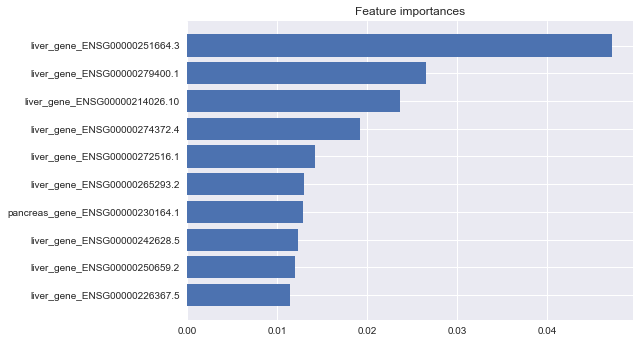

In [123]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

forest = t_regr
feature_count = 10


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:feature_count]

print("Feature ranking:")

for f in range(feature_count):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
 
print(feature_names.shape)
names = [feature_names[i] for i in indices]

plt.style.use('seaborn')

plt.figure()
plt.title("Feature importances")
plt.barh(range(feature_count - 1, -1, -1), importances[indices], align="center")
#yerr=std[indices]
print(names)
#print(std[indices])
# Add feature names as x-axis labels
plt.yticks(range(feature_count - 1, -1, -1), names, rotation=0)

# plt.xticks(range(feature_count), indices)
# plt.xlim([-1, feature_count])
plt.savefig('feature_importance')

In [50]:
from sklearn.neighbors import KNeighborsRegressor
for n_neighbors in [50]:
    KNN = KNeighborsRegressor(n_neighbors=n_neighbors)
    KNN.fit(x_train, y_train)
    x_val = dataset_val.loc[:, features].values
    y_val = dataset_val.loc[:,[target]].values
    y_val_pred = KNN.predict(x_val)

    print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))    
    print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
    print('----------------------------------')

Mean squared error: 0.0158
Coefficient of determination: -1.83
----------------------------------


In [51]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Product
#kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor()
gpr.fit(x_train, y_train)
x_val = dataset_val.loc[:, features].values
y_val = dataset_val.loc[:,[target]].values
y_val_pred = gpr.predict(x_val)

print('Mean squared error: %.4f' % mean_squared_error(y_val, y_val_pred))    
print('Coefficient of determination: %.2f' % r2_score(y_val, y_val_pred))
print('----------------------------------')

Mean squared error: 0.0530
Coefficient of determination: -8.49
----------------------------------
